# 2. R-loop InDelsTopo Analysis

In this notebook, we analyze R-loop sequence libraries using the **Insertion Chain Complex**, implemented in the package **InDelsTopo**. We work with the preprocessed R-loop data generated in `1_Preprocess_Data.ipynb`.

In the underlying experiments, R-loops form at prescribed starting positions on DNA plasmids with varying topologies: **linearized**, **supercoiled**, or **gyrase-treated supercoiled**. Each plasmid contains sequences of known composition, and high-throughput single-molecule R-loop footprinting (SMRF-seq) identifies the starting locations of R-loops. From these data, we extract short DNA subsequences (k-mers) surrounding the R-loop start sites, generating frequency tables of words at each experimental condition.

The input data analyzed here consists of **libraries of k-mers with normalized frequencies**, representing the distribution of DNA words at R-loop starting points. Only the top $N=500$ words per experiment are retained, ensuring robust statistical representation.

### Conclusion

These results provide strong evidence that **DNA topology influences the sequence composition at R-loop starting points**. In particular, the **topological signatures derived from Insertion Chain Complexes** (Euler Characteristic curves and persistent diagrams) can distinguish linearized plasmids from coiled and supercoiled plasmids, reflecting the structural constraints imposed by DNA topology.


In [35]:
import pickle
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

from InDelsTopo import Filtration
from persim import plot_diagrams, bottleneck

from utils.utils import plot_euler_curves, plot_tsne, plot_dendrogram


In [31]:
#Load preprocessed libraries
# --------------------------

# Path to the saved pickle file
pickle_file = 'data/preprocessed/R_loops_14-mers_starting_site.pickle'

# Load the libraries
with open(pickle_file, 'rb') as handle:
    Libraries = pickle.load(handle)

## A. Computing Filtrations and Topological Signatures

We begin by loading the preprocessed R-loop libraries from:  
`data/preprocessed/R_loops_14-mers_starting_site.pickle`.

For each experiment, we construct a **Filtration of Insertion Chain Complexes** using the `Filtration` object from **InDelsTopo**. The normalized word frequencies are used as weights for the words. 

As a topological signature, we compute **Euler Characteristic curves** for each filtration. These curves are sampled over a common set of x-coordinates (`xx = np.arange(0,1,0.01)`) and capture the topological structure of the DNA word collections.

In [32]:
# Compute filtrations and Euler curves
# --------------------------

#Common x-coordinates for Euler Characteristic curves
xx=np.arange(0,1,0.01)

#Compute them
exp_names=[]
filtrations=[]
euler_curves=[]

for lib in Libraries:
    exp_name = lib['exp_name']
    Table = lib['table']
    Words, Freqs = Table['Words'], Table['Freqs']

    K = Filtration()
    K.compute_d_skeleton(Words, Freqs)
    K.exp_name = exp_name

    exp_names.append(exp_name)
    filtrations.append(K)
    euler_curves.append(K.get_euler_curve(xx))

Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)


## B. Visualization of Euler Characteristic Curves

The Euler Characteristic curves are visualized. These plots reveal clear differences between DNA topologies.

We project these curves into **2D using t-SNE**, which shows clustering of experiments by DNA topology: there's a clear separation between Linearized experiments and the remaing ones. Experiments are color-coded according to plasmid topology to highlight separation. 


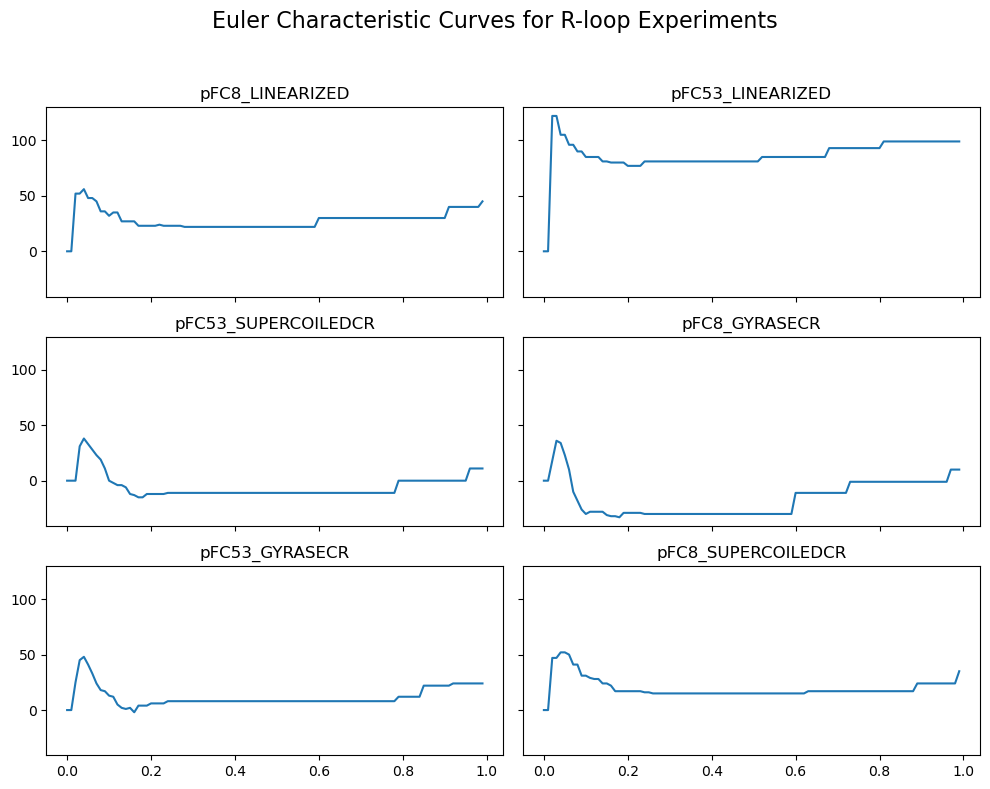

In [33]:
# Plotting Euler Characteristic Curves
# --------------------------
plot_euler_curves(exp_names, euler_curves, title="Euler Characteristic Curves for R-loop Experiments")

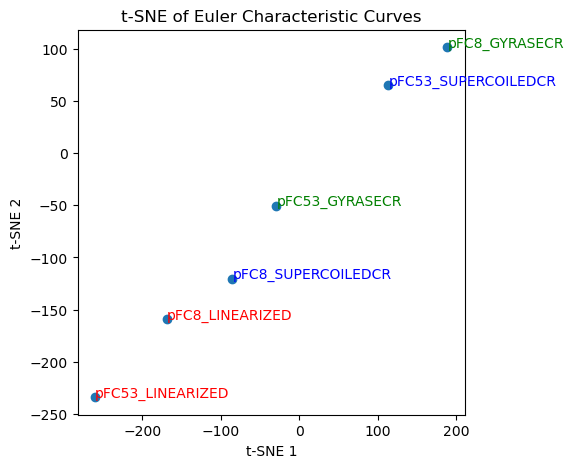

In [34]:
# Plotting t-SNE projection
# --------------------------
plot_tsne(exp_names, euler_curves, title='t-SNE of Euler Characteristic Curves')

## C. Persistent Diagrams and Bottleneck Clustering

We extract **persistent homology barcodes** (H0, H1, and H2) for each filtration. Infinite death times are replaced by the finite value 2 to allow computation of **bottleneck distances**.  

Using the pairwise bottleneck distances, we perform **hierarchical clustering**. The resulting dendrogram shows again a clear separation of experiments according to plasmid topology, with the Linearized plasmids forming a separate cluster.  

pFC8_LINEARIZED


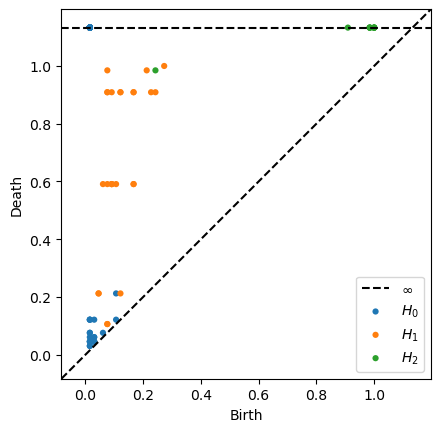

pFC53_LINEARIZED


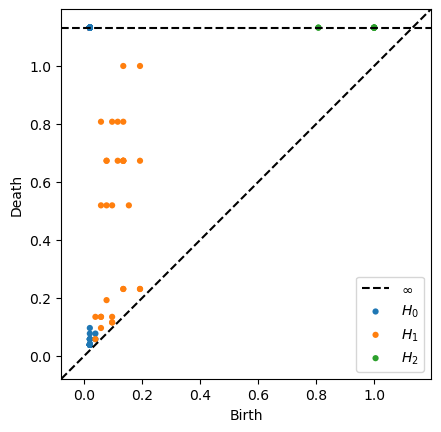

pFC53_SUPERCOILEDCR


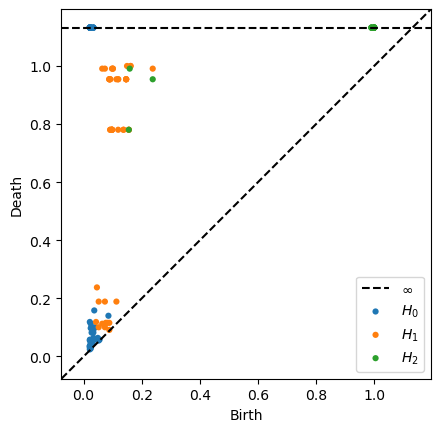

pFC8_GYRASECR


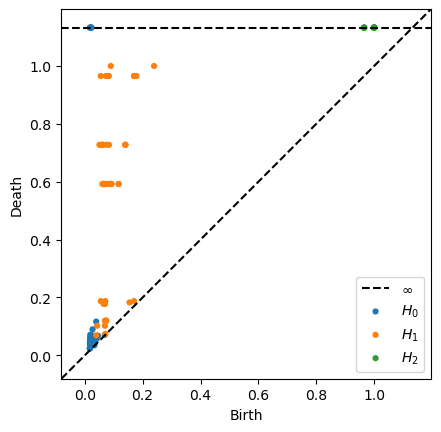

pFC53_GYRASECR


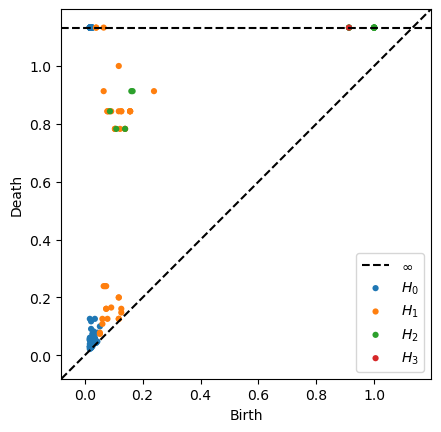

pFC8_SUPERCOILEDCR


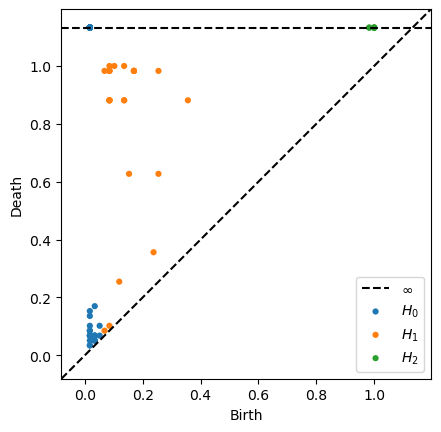

In [6]:
INF_REPLACEMENT=2

# Compute persistence diagrams for all filtrations
# --------------------------
all_dgms = []

for i, filtration in enumerate(filtrations):
    dgms0 = filtration.get_persistent_homology_barcodes()
    
    # Convert to list of numpy arrays
    dgms = [np.array(dgms0[j]) for j in range(len(dgms0))]

    # Plot diagrams
    print(exp_names[i])
    plot_diagrams(dgms, show=True)

    for dgm in dgms:
        # Replace inf with prescribed value
        dgm[np.isinf(dgm)] = INF_REPLACEMENT
    all_dgms.append(dgms)

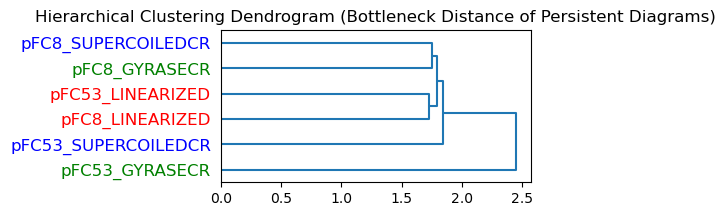

In [51]:
# Compute pairwise bottleneck distances (using H0 and H1 combined)
# --------------------------
num_exp = len(all_dgms)
distance_matrix = np.zeros((num_exp, num_exp))

for i in range(num_exp):
    for j in range(i+1, num_exp):
        # Compute bottleneck distance for H0 + H1 diagrams
        # Optionally, can weight H1 differently
        d0 = bottleneck(all_dgms[i][0], all_dgms[j][0])  # H0
        d1 = bottleneck(all_dgms[i][1], all_dgms[j][1])  # H1
        d2 = bottleneck(all_dgms[i][2], all_dgms[j][2])  # H2
        
        distance = d0 + d1 + d2  # simple sum, or choose max
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# Hierarchical clustering
# --------------------------

agg = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average',compute_distances=True)
agg.fit(distance_matrix)

plt.figure(figsize=(4,4))
plt.title("Hierarchical Clustering Dendrogram (Bottleneck Distance of Persistent Diagrams)")
plot_dendrogram(agg, labels=exp_names)